In [1]:
########################################## Import packages ##########################################
import sys
import pandas as pd
import seaborn as sns
import scipy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import tensorflow as tf
# building new cudnn lib from: https://macjim.medium.com/loading-alternative-cudnn-library-versions-in-tensorflow-90c7472e361a
# tf.load_library('/home/ubuntu/anaconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib')
from tensorflow import keras
from tensorflow.keras import layers

# Set preferences
tf.random.set_seed(42)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Training XGBoost
# import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statistics import mean

sys.path.append('../src/')
sys.path.append('../Scripts/')

from  SequenceDataLoader import SequenceDataLoader
from get_data_loader import get_data_loader

In [ ]:
############################################## LOAD DATA ##############################################
TEST_PATH = '../../Datasets/urbanization_test.csv'
# test data, Ohio region
test_data = pd.read_csv(TEST_PATH) # change
# Test
mean_urbanization_by_tile = test_data.groupby('tile_id')['urbanization'].mean()
test_data_f = test_data[test_data['tile_id'].map(mean_urbanization_by_tile) > 0]

IMG_DIR_TEST = '../../Images/Test/'
IMG_SIZE = (40, 44)
BATCH_SIZE = 64
N_CHANNELS = 1
LABELS = [2016, 2017, 2018, 2019] #, 2020, 2021
YEAR = 2020

data_wide = test_data.pivot_table(index='tile_id', columns='year', values='urbanization', aggfunc='first')
data_wide = data_wide.merge(right=test_data[['tile_id', 'Lat', 'Lon']], on='tile_id')
data_wide.drop_duplicates(inplace = True, ignore_index = True)
tab_data = data_wide.drop(columns = ["tile_id", 2022]) #.to_dict(orient='index')

YEAR = 2020
test_data_loader20 = get_data_loader(test_data_f, IMG_DIR_TEST, IMG_SIZE, BATCH_SIZE, LABELS, N_CHANNELS, YEAR) #, TAB_DATA = tab_data)
YEAR = 2021
test_data_loader21 = get_data_loader(test_data_f, IMG_DIR_TEST, IMG_SIZE, BATCH_SIZE, LABELS, N_CHANNELS, YEAR) #, TAB_DATA = tab_data)
YEAR = 2022
test_data_loader22 = get_data_loader(test_data_f, IMG_DIR_TEST, IMG_SIZE, BATCH_SIZE, LABELS, N_CHANNELS, YEAR) #, TAB_DATA = tab_data)



In [5]:
X, y = test_data_loader20[0]

In [6]:

############################################## MODEL ##############################################
def create_model(inp1_shape):
    # Construct the input layer with 4 time frames in input
    inp1 = layers.Input(shape=(4, *inp1_shape))
    # inp2 =  layers.Input(shape=inp2_shape)

    # ConvLSTM layers
    x1 = layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
        recurrent_activation="relu", # hard_sigmoid
    )(inp1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ConvLSTM2D(
        filters=8,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ConvLSTM2D(
      filters=8,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
    )(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x1)
    x1_a = layers.GlobalAveragePooling3D()(x1)  # Add Global Average Pooling to collapse spatial dimensions
    x1_b = layers.GlobalMaxPooling3D()(x1)
    x = layers.concatenate([x1_a, x1_b])

    # Feedforward Layers
    # x2 = layers.Dense(8, activation='linear')(inp2)
    # x2 = layers.Dense(16, activation='relu')(x2)
    # x2 = layers.Dense(8, activation='relu')(x2)

    # concatenate before passing to next layer
    #x = layers.concatenate([x1, x2])

    X = layers.Dense(8, activation='relu')(x)
    # Add a Dense layer with a single unit and sigmoid activation
    x = layers.Dense(1, activation="sigmoid")(x)

    # ADAPT THE FOLLOWING TO MY CODE
    # Next, we will build the complete model and compile it.
    model = keras.models.Model(inp1, x)
    loss = tf.keras.losses.MeanSquaredError()  #tf.keras.losses.MeanAbsoluteError() # tf.keras.losses.MeanSquaredError() #keras.losses.binary_crossentropy
    optim = keras.optimizers.Adam()#learning_rate=0.1)
    model.compile(optimizer='adam', loss = loss, metrics = ['mae'])#weighted_mse_with_class)

    return model

In [7]:
######################################### GPUs #######################################################
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [8]:
# Define input shapes
inp1_shape = X.shape[2:]

# Train the model from scratch
model = create_model(inp1_shape) 
model20 = tf.keras.models.load_model('../Models/conv-lstm-DW-20-2020')
model21 = tf.keras.models.load_model('../Models/conv-lstm-DW-20-2021')
model22 = tf.keras.models.load_model('../Models/conv-lstm-DW-20-2022')

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tf/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2023-08-15 15:20:05.508 ip-10-0-12-249:3432 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-08-15 15:20:05.565 ip-10-0-12-249:3432 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [13]:
def get_predictions(model, data_loader, historical_df):
    results = {'BatchID':[], 'TileID':[],'Y':[], 'Pred':[], '2017':[], '2018':[], '2019':[], '2020':[], '2021':[], '2022':[]}
    n_batches = len(data_loader)
    for batch in tqdm(range(n_batches)):
        
        tile_ids = []
        batch_ids = []
        historical_2017, historical_2018, historical_2019, historical_2020, historical_2021, historical_2022 = [], [], [] ,[], [], []
        for key in data_loader.batches[batch].keys():
            tile_ids_key = data_loader.batches[batch][key]
            batch_id = int(key.split('_')[-1])
            batch_ids_key = [batch_id]* len(tile_ids_key)
            for tile_id in tile_ids_key:
                val17, val18, val19, val20, val21, val22 = historical_df[(historical_df['batch_id'] == batch_id) & (historical_df['tile_id']== tile_id)]['urbanization']
                historical_2017.append(val17)
                historical_2018.append(val18)
                historical_2019.append(val19)
                historical_2020.append(val20)
                historical_2021.append(val21)
                historical_2022.append(val22)
            tile_ids += tile_ids_key
            batch_ids += batch_ids_key
        
        X, y = data_loader[batch]
        pred = model.predict(X)
        # print('pred:', pred) 

        assert len(tile_ids) == len(X) == len(pred) == len(historical_2017) == len(historical_2018) == len(historical_2019) == len(historical_2020) == len(historical_2021) == len(historical_2022)
        
        # add data to results dataframe 
        results['BatchID'] += batch_ids
        results['TileID'] += tile_ids
        results['Y'] += list(y)
        results['Pred'] += [item[0] for item in pred]
        results['2017'] += historical_2017
        results['2018'] += historical_2018
        results['2019'] += historical_2019
        results['2020'] += historical_2020
        results['2021'] += historical_2021
        results['2022'] += historical_2022
    
    results_df = pd.DataFrame.from_dict(results)
    return results_df


In [15]:
# predicting for 2020
print('Generating predictions for 2020 - next year prediction')
results_df20 = get_predictions(model20, test_data_loader20, test_data_f)
print()
# predicting for 2021
print('Generating predictions for 2021 - 1y lag prediction')
results_df21 = get_predictions(model21, test_data_loader21, test_data_f)
print()
# predicting for 2022
print('Generating predictions for 2022 - 2y lag prediction')
results_df22 = get_predictions(model22, test_data_loader22, test_data_f)

  0%|          | 0/2487 [00:00<?, ?it/s]

Generating predictions for 2020 - next year prediction


  0%|          | 0/2487 [00:00<?, ?it/s]


Generating predictions for 2021 - 1y lag prediction


  0%|          | 0/2487 [00:00<?, ?it/s]


Generating predictions for 2022 - 2y lag prediction


100%|██████████| 2487/2487 [20:12<00:00,  2.05it/s]


In [16]:
# adding residuals to the dataframe 
results_df20['residuals'] = results_df20['2020'] -results_df20['Pred']
results_df21['residuals'] = results_df21['2021'] -results_df21['Pred']
results_df22['residuals'] = results_df22['2022'] -results_df22['Pred']


In [17]:
## saving results
results_df20.to_csv('../../Results/results_df20.csv', index=False)
results_df21.to_csv('../../Results/results_df21.csv', index=False)
results_df22.to_csv('../../Results/results_df22.csv', index=False)

# Lag Prediction Analysis


In [2]:
## reading in results dataframes
results_df20 = pd.read_csv('../../Results/results_df20.csv')
results_df21 = pd.read_csv('../../Results/results_df21.csv')
results_df22 = pd.read_csv('../../Results/results_df22.csv')

### Analysis for 1 year lag predictions
This model takes as input the tile images in [2016, 2017, 2018, 2019] and predicts the urbanization of the tile in 2020

In [4]:
results_df20.head()

,BatchID,TileID,Y,Pred,2017,2018,2019,2020,2021,2022,residuals
0,67,238208,0.050510,0.043604,0.021429,0.024490,0.024490,0.050510,0.057653,0.061224,0.006907
1,67,238211,0.011735,0.005264,0.008163,0.010204,0.011735,0.011735,0.011735,0.011735,0.006470
2,67,238212,0.018878,0.020032,0.018878,0.018878,0.018878,0.018878,0.018878,0.018878,-0.001154
3,67,238217,0.127551,0.129191,0.081122,0.093878,0.120408,0.127551,0.127551,0.127551,-0.001640
4,67,238218,0.525510,0.538731,0.341837,0.396939,0.518878,0.525510,0.530102,0.530102,-0.013221


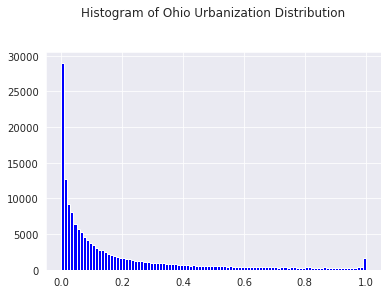

In [5]:
# distribution of urbanization
plt.hist(results_df20.Y, bins=100, color = "blue")
plt.title('Histogram of Ohio Urbanization Distribution\n\n')
plt.show()

Text(0, 0.5, 'Residuals')

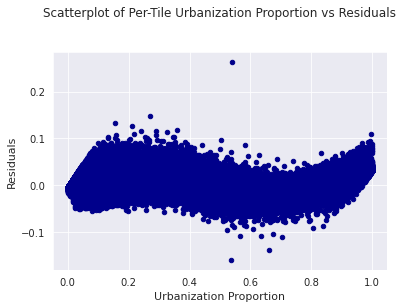

In [6]:
# we underpredict on tiles with urbanization below 50% and overpredict for tiles with urbanization above 50%
# residual = actual - pred
ax1 = results_df20.plot.scatter(x='Y', y='residuals', c='DarkBlue', title = 'Scatterplot of Per-Tile Urbanization Proportion vs Residuals\n\n')
ax1.set_xlabel('Urbanization Proportion', fontsize=11)
ax1.set_ylabel('Residuals', fontsize=11)
# How does the model perform for different levels of urbanization proportions?

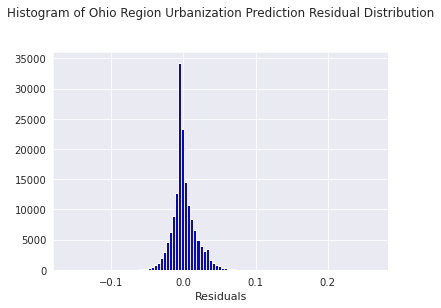

In [7]:
# distribution of y variable
plt.hist(results_df20['residuals'], bins=100, color = "blue")
plt.title('Histogram of Ohio Region Urbanization Prediction Residual Distribution\n\n')
plt.xlabel('Residuals', fontsize=11)
plt.show()

Text(0, 0.5, 'Urbanization Proportion Prediction')

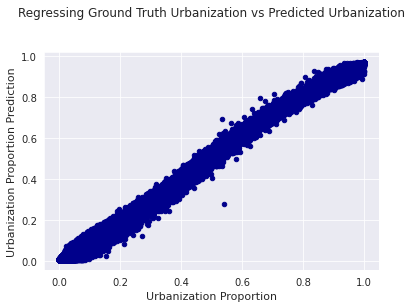

In [8]:
### checking how closely the target variable relates to the predictions
results_df20.plot.scatter(x='Y', y='Pred', c='DarkBlue')
plt.title('Regressing Ground Truth Urbanization vs Predicted Urbanization\n\n')
plt.xlabel('Urbanization Proportion', fontsize=11)
plt.ylabel('Urbanization Proportion Prediction', fontsize=11)

In [51]:
def urban_magnitude_perform(df, lag, n_bins = 5):
    """ Takes as input the dataframe including the actual urbanization value and the residuals and generates a figure which allows us to compare the urbanization performance per bucket of urbanization magnitude
        Args: dataframe, n_bins - number of bins to divide the data into, uniformly distributed along the [0,1] scale eg: 5 bins would bucket the data as follows: [[0,0.2), [0.2, 0.4), [0.4,0.6), [0.6,0.8), [0.8,1)]
        Returns: None - prints plot 
    """
    bins = np.arange(start=0, stop=1, step=1/n_bins)
    fig, ax = plt.subplots(n_bins, tight_layout=True, figsize=(6,15))
    fig.suptitle('Vertically stacked residual distribution subplots for {} year lag predictions\n Residuals = Actual - Predicted\n\n'.format(lag))
    for i, bin in enumerate(bins):
        df_bin = df[(df.Y >= bin) & (df.Y < bin+1/n_bins)]
        ax[i].hist(df_bin['residuals'], bins=100, color = "blue")
        ax[i].title.set_text('Distribution of prediction residuals for [{},{}) urbanization proportion range'.format(bin, bin+1/n_bins))
        ax[i].set_xlim([-0.15, 0.15])
    


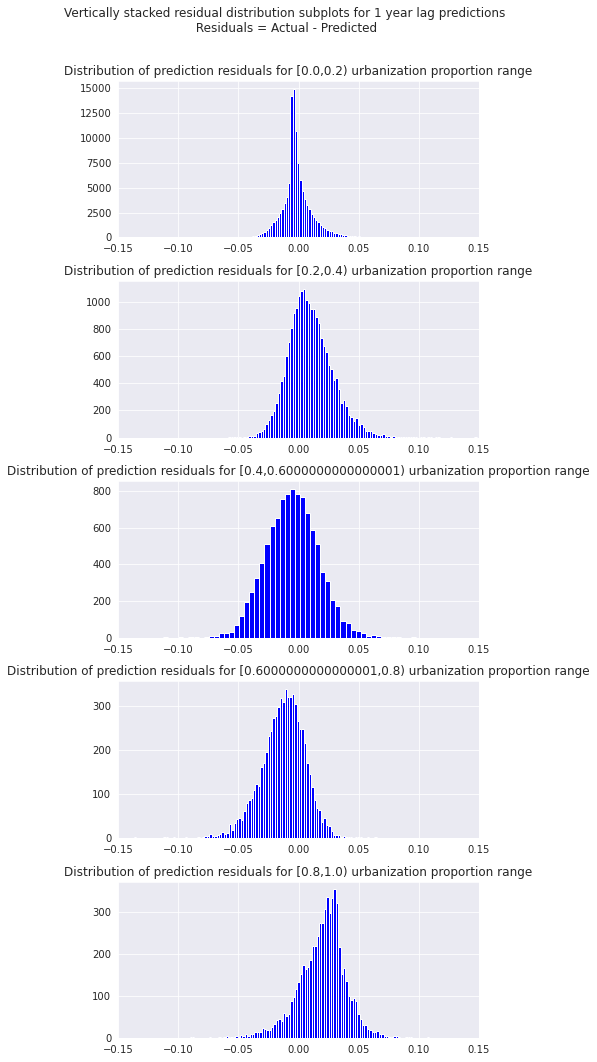

In [52]:
urban_magnitude_perform(results_df20, lag=1, n_bins=5)
## overpredict [0,0.2]
## underpredicting [0.2,0.4]


In [53]:
# BASELINE: Use previous year as the prediction for the next year
slope_b, intercept_b, r_value_b, p_value_b, std_err_b = scipy.stats.linregress(results_df20['2019'], results_df20['2020'])
# MODEL PREDICTION: Use ConvLSTM model to predict urbanization in the next year
slope_m, intercept_m, r_value_m, p_value_m, std_err_m = scipy.stats.linregress(results_df20['Y'], results_df20['Pred'])

print('Baseline Perfformance:')
print('slope:', slope_b)
print('intercept:', intercept_b)
print('r_value:', r_value_b)
print('p_value:', p_value_b)
print('std_err:', std_err_b)
print()
print('Model Performance:')
print('slope:', slope_m)
print('intercept:', intercept_m)
print('r_value:', r_value_m)
print('p_value:', p_value_m)
print('std_err:', std_err_m)

Baseline Perfformance:
slope: 1.0119067111936069
intercept: 0.007388745033233779
r_value: 0.9954189202929159
p_value: 0.0
std_err: 0.00024364536614874605

Model Performance:
slope: 0.9882509358748748
intercept: 0.0017199140492422937
r_value: 0.9976989825721128
p_value: 0.0
std_err: 0.00016835083981774996


### Analysis for 2 year lag predictions
This model takes as input the tile images in [2016, 2017, 2018, 2019] and predicts the urbanization of the tile in 2021

In [54]:
results_df21.head()

,BatchID,TileID,Y,Pred,2017,2018,2019,2020,2021,2022,residuals
0,17,47874,0.008000,0.015206,0.000000,0.008000,0.008000,0.008000,0.008000,0.008000,-0.007206
1,17,47878,0.142857,0.116296,0.022959,0.107143,0.120918,0.133673,0.142857,0.153571,0.026561
2,17,47879,0.019388,0.029389,0.000000,0.019388,0.019388,0.019388,0.019388,0.019388,-0.010001
3,17,47884,0.003061,0.018978,0.003061,0.003061,0.003061,0.003061,0.003061,0.003061,-0.015917
4,17,47885,0.048500,0.053241,0.039500,0.045500,0.048500,0.048500,0.048500,0.052000,-0.004741


Text(0, 0.5, 'Residuals')

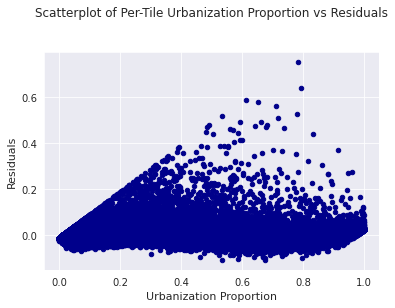

In [55]:
# comments??
ax1 = results_df21.plot.scatter(x='Y', y='residuals', c='DarkBlue', title = 'Scatterplot of Per-Tile Urbanization Proportion vs Residuals\n\n')
ax1.set_xlabel('Urbanization Proportion', fontsize=11)
ax1.set_ylabel('Residuals', fontsize=11)
#How does the model perform for different levels of urbanization proportions?

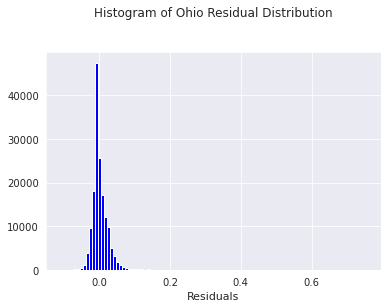

In [56]:
# distribution of y variable
plt.hist(results_df21['residuals'], bins=100, color = "blue")
plt.title('Histogram of Ohio Residual Distribution\n\n')
plt.xlabel('Residuals', fontsize=11)
plt.show()

Text(0, 0.5, 'Urbanization Prediction')

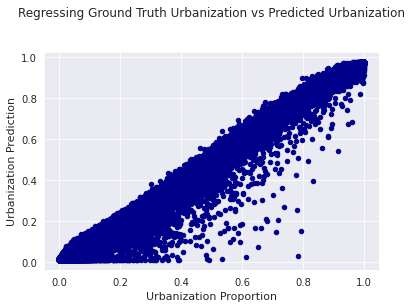

In [57]:
### checking how closely the target variable relates to the predictions
results_df21.plot.scatter(x='Y', y='Pred', c='DarkBlue')
plt.title('Regressing Ground Truth Urbanization vs Predicted Urbanization\n\n')
plt.xlabel('Urbanization Proportion', fontsize=11)
plt.ylabel('Urbanization Prediction', fontsize=11)
# consistently underpredicting urbanization

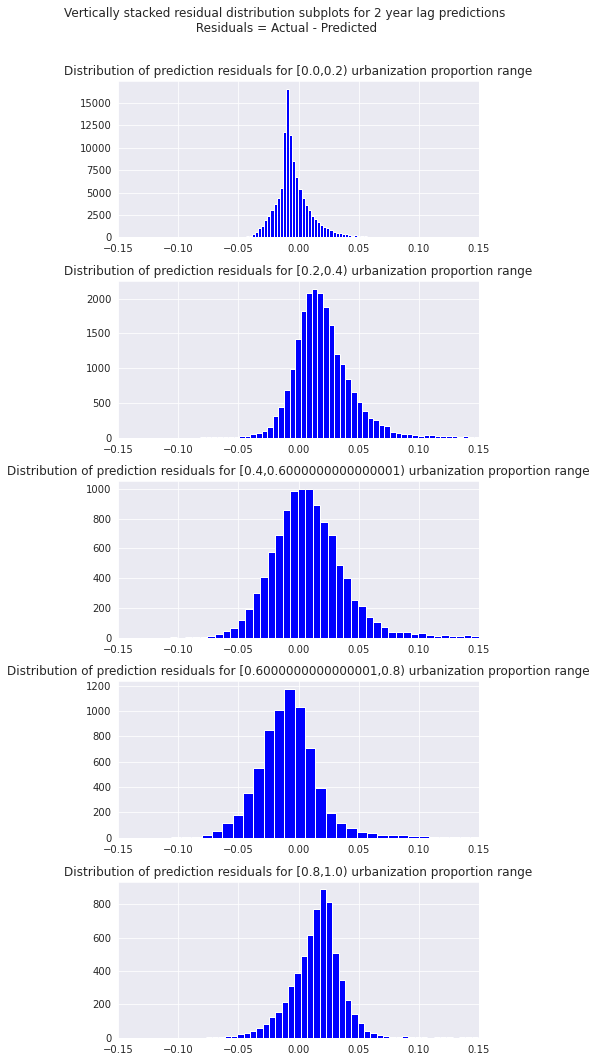

In [58]:
urban_magnitude_perform(results_df21, lag=2, n_bins=5)

In [59]:
# BASELINE: Use previous year as the prediction for the next year
slope_b, intercept_b, r_value_b, p_value_b, std_err_b = scipy.stats.linregress(results_df21['2019'], results_df21['2021'])
# MODEL PREDICTION: Use ConvLSTM model to predict urbanization in the next year
slope_m, intercept_m, r_value_m, p_value_m, std_err_m = scipy.stats.linregress(results_df21['Y'], results_df21['Pred'])

print('Baseline Perfformance:')
print('slope:', slope_b)
print('intercept:', intercept_b)
print('r_value:', r_value_b)
print('p_value:', p_value_b)
print('std_err:', std_err_b)
print()
print()
print('Model Performance:')
print('slope:', slope_m)
print('intercept:', intercept_m)
print('r_value:', r_value_m)
print('p_value:', p_value_m)
print('std_err:', std_err_m)

Baseline Perfformance:
slope: 1.0146215986771292
intercept: 0.013090612145284952
r_value: 0.9905853159914595
p_value: 0.0
std_err: 0.00035150223701929786


Model Performance:
slope: 0.9731892271864409
intercept: 0.003738311895173624
r_value: 0.9948673209289441
p_value: 0.0
std_err: 0.00024813258179702985


### Analysis for 3 year lag predictions
This model takes as input the tile images in [2016, 2017, 2018, 2019] and predicts the urbanization of the tile in 2022

In [60]:
results_df22.head()

,BatchID,TileID,Y,Pred,2017,2018,2019,2020,2021,2022,residuals
0,28,95360,0.025000,0.023279,0.000000,0.000000,0.008673,0.009694,0.021429,0.025000,0.001721
1,28,95363,0.184694,0.158724,0.125510,0.148980,0.158673,0.168367,0.169388,0.184694,0.025970
2,28,95364,0.480612,0.460794,0.348980,0.360204,0.453061,0.456122,0.480102,0.480612,0.019819
3,28,95367,0.113776,0.130337,0.041837,0.060714,0.107653,0.107653,0.113265,0.113776,-0.016562
4,28,95368,0.015500,0.023200,0.006000,0.006000,0.013000,0.013000,0.014000,0.015500,-0.007700


Text(0, 0.5, 'Residuals')

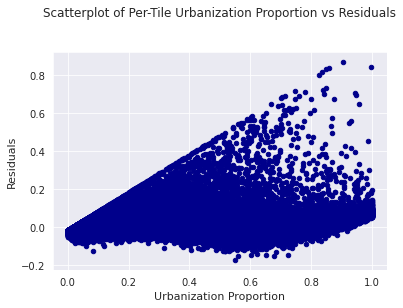

In [64]:
# comments??
ax1 = results_df22.plot.scatter(x='Y', y='residuals', c='DarkBlue', title ='Scatterplot of Per-Tile Urbanization Proportion vs Residuals\n\n')
ax1.set_xlabel('Urbanization Proportion', fontsize=11)
ax1.set_ylabel('Residuals', fontsize=11)

# we are underpredicting 

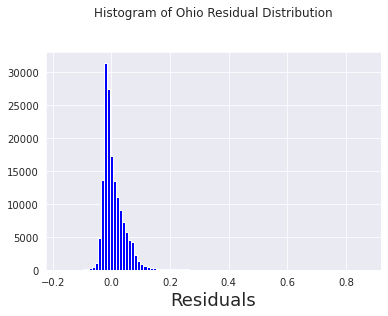

In [65]:
# distribution of y variable
plt.hist(results_df22['residuals'], bins=100, color = "blue")
plt.title('Histogram of Ohio Residual Distribution\n\n')
plt.xlabel('Residuals', fontsize=11)
plt.show()

Text(0, 0.5, 'Urbanization Prediction')

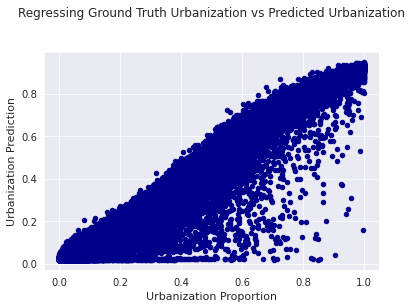

In [70]:
### checking how closely the target variable relates to the predictions
results_df22.plot.scatter(x='Y', y='Pred', c='DarkBlue')
plt.title('Regressing Ground Truth Urbanization vs Predicted Urbanization\n\n')
plt.xlabel('Urbanization Proportion', fontsize=11)
plt.ylabel('Urbanization Prediction', fontsize=11)

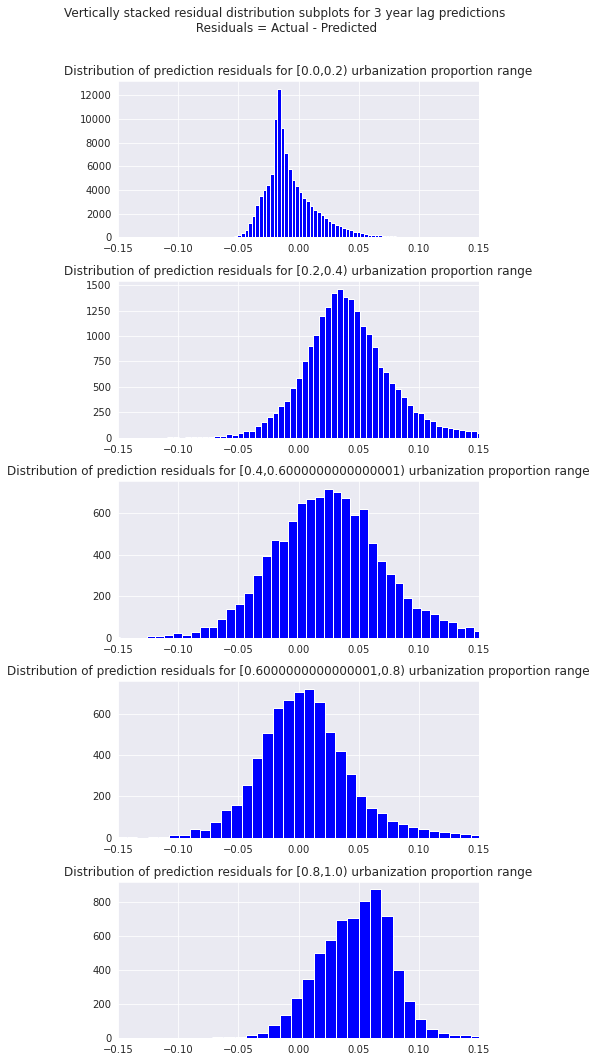

In [72]:
urban_magnitude_perform(results_df22, lag=3, n_bins=5)

In [73]:
# BASELINE: Use previous year as the prediction for the next year
slope_b, intercept_b, r_value_b, p_value_b, std_err_b = scipy.stats.linregress(results_df22['2019'], results_df22['2022'])
# MODEL PREDICTION: Use ConvLSTM model to predict urbanization in the next year
slope_m, intercept_m, r_value_m, p_value_m, std_err_m = scipy.stats.linregress(results_df22['Y'], results_df22['Pred'])

print('Baseline Perfformance:')
print('slope:', slope_b)
print('intercept:', intercept_b)
print('r_value:', r_value_b)
print('p_value:', p_value_b)
print('std_err:', std_err_b)
print()
print()
print('Model Performance:')
print('slope:', slope_m)
print('intercept:', intercept_m)
print('r_value:', r_value_m)
print('p_value:', p_value_m)
print('std_err:', std_err_m)

Baseline Perfformance:
slope: 1.0171556649483466
intercept: 0.018427153231019622
r_value: 0.9845155925582096
p_value: 0.0
std_err: 0.00045400640562582017


Model Performance:
slope: 0.9185503918418858
intercept: 0.0078066911713039755
r_value: 0.985424616904823
p_value: 0.0
std_err: 0.0003975015934960841


# Does the urbanization rate affect the predictive performance of the model?

### 1Y lag data

In [3]:
def add_urbanization_rate(df):
    """
        For each year add the urbanization rate as a column to the data
    """
    years = [2017, 2018, 2019]
    for y in years[:-1]:
        df['UR_{}_{}'.format(str(y)[2:], str(y+1)[2:])] = df[str(y+1)]-df[str(y)]
    return df

In [4]:
results_df20 = add_urbanization_rate(results_df20)
results_df21 = add_urbanization_rate(results_df21)
results_df22 = add_urbanization_rate(results_df22)


In [119]:
def high_residual_URanalysis(df, threshold=0.1):
    years = [2017, 2018, 2019]
    leq = df[df.residuals<=threshold]
    geq = df[df.residuals>threshold]

    fig, ax = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(15,15))
    fig.suptitle('Vertically stacked urbanization rate distribution subplots for periods 17-18 and 18-19\n')
    comment_fill = ['All Regions', 'Regions with Low Residuals', 'Regions with High Residuals']
    for i, tb in enumerate([df, leq, geq]):
        ax[i, 0].hist(tb['UR_17_18'], bins=100, color = "blue")
        ax[i, 1].hist(tb['UR_18_19'], bins=100, color = "blue")
        ax[i, 0].title.set_text('Distribution of Urbanization Rate \n for UR_17_18 for {}\n'.format(comment_fill[i]))
        ax[i, 1].title.set_text('Distribution of Urbanization Rate \n for UR_18_19 for {}\n'.format(comment_fill[i]))

 

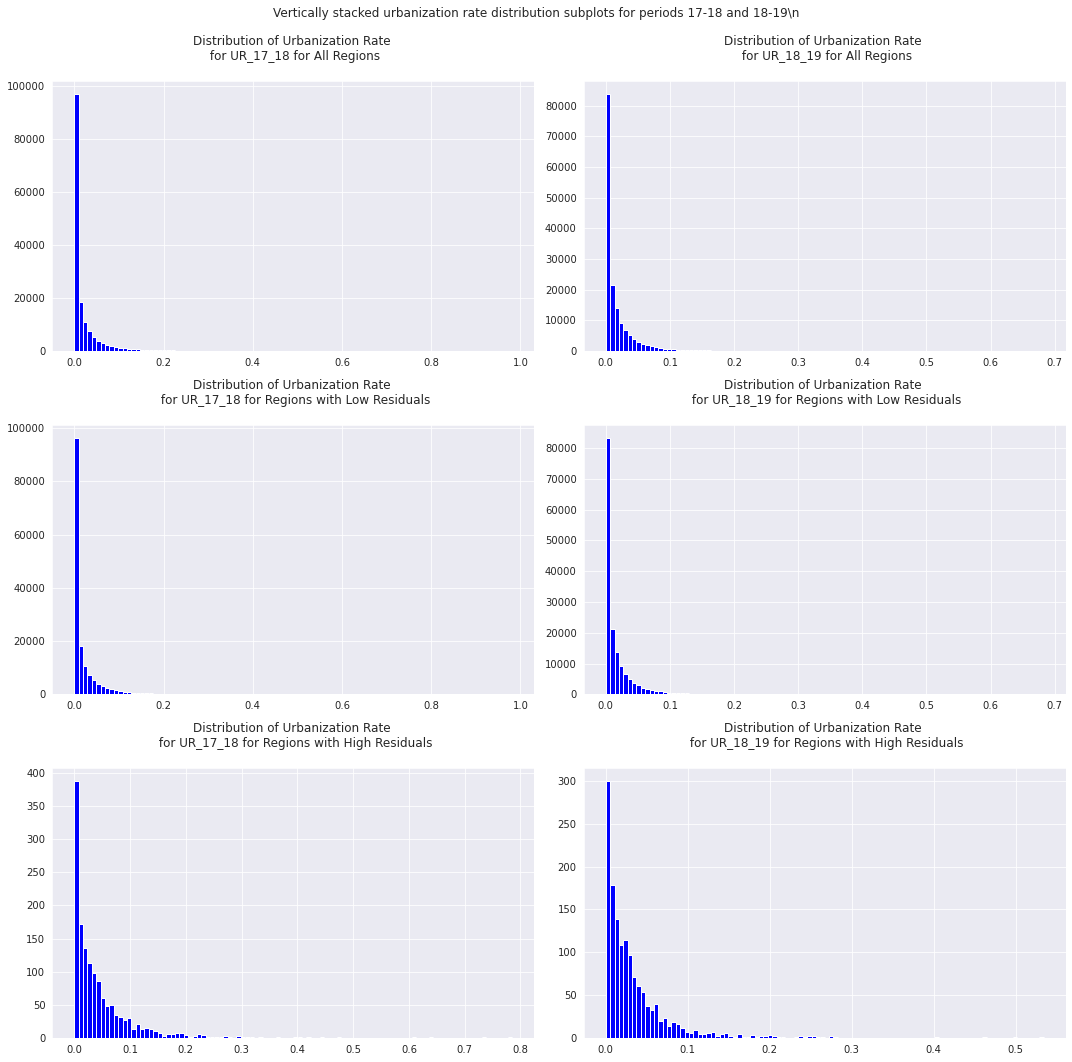

In [121]:
# 1Y LAG MODEL
high_residual_URanalysis(results_df20, threshold=0.05)

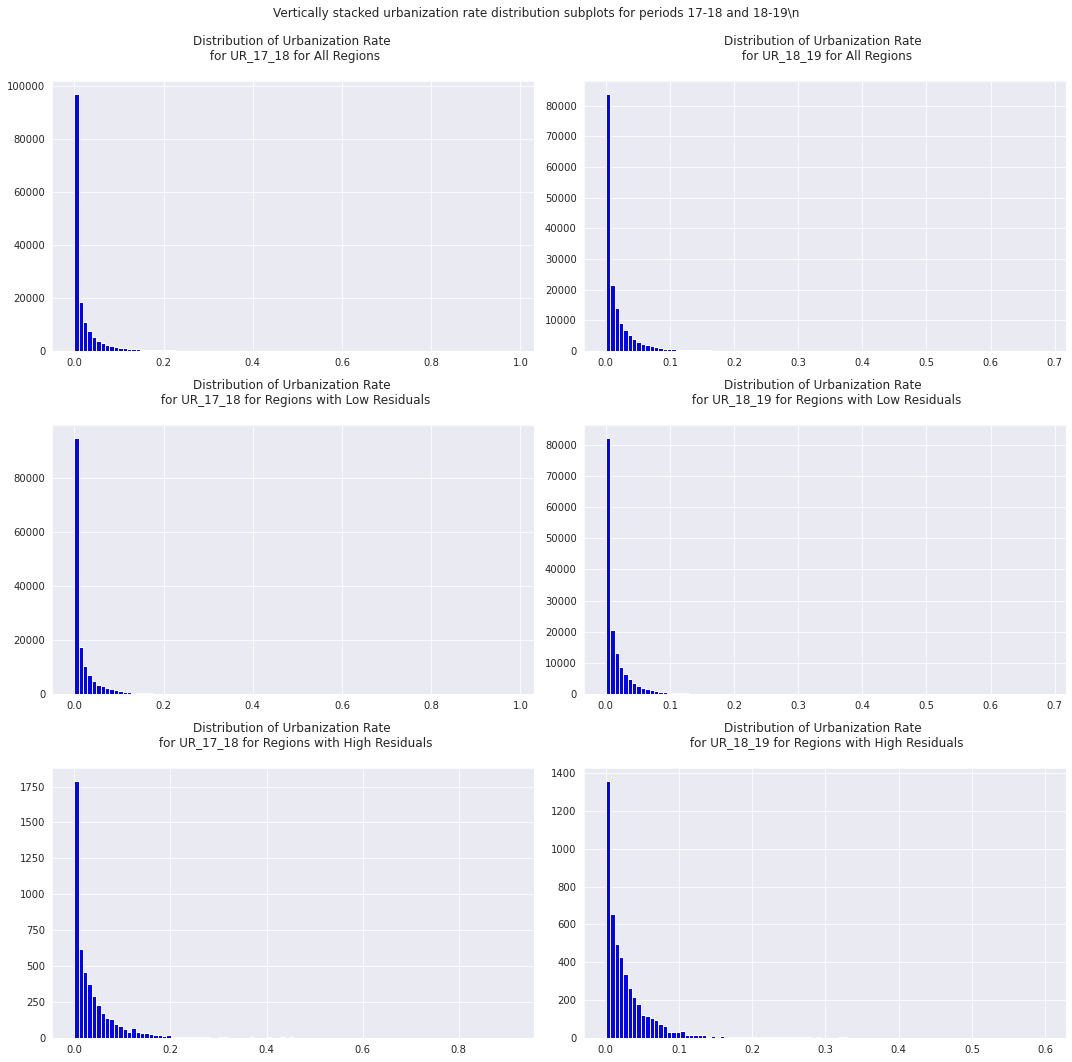

In [122]:
# 2Y LAG MODEL
high_residual_URanalysis(results_df21, threshold=0.05)

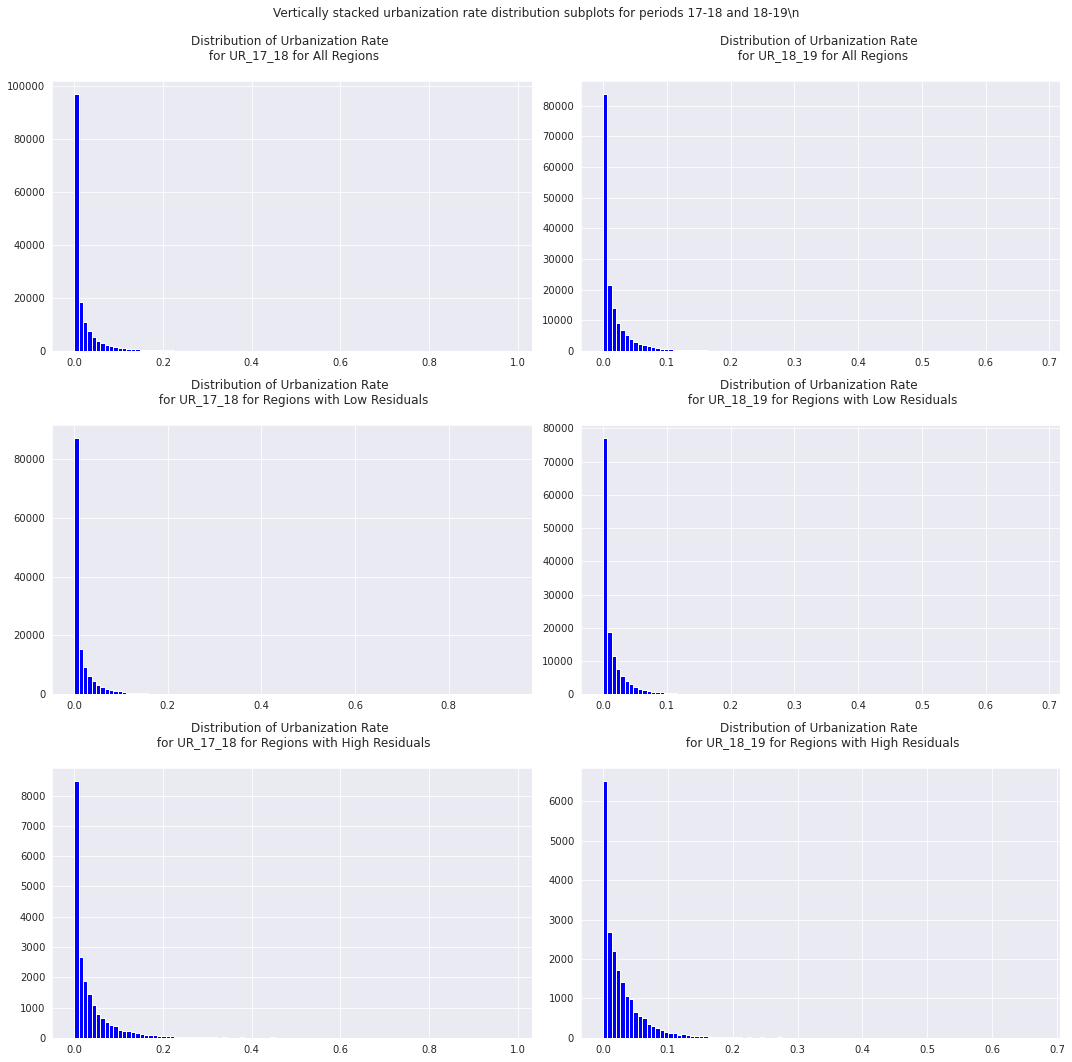

In [123]:
# 3Y LAG MODEL
high_residual_URanalysis(results_df22, threshold=0.05)

### Urbanization rate 

In [14]:
def high_residual_URanalysis(df, threshold=0.1):
    years = [2017, 2018, 2019]
    leq = df[df.residuals<=threshold]
    geq = df[df.residuals>threshold]

    fig, ax = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(15,15))
    fig.suptitle('Vertically stacked urbanization rate distribution subplots for periods 17-18 and 18-19\n')
    comment_fill = ['All Regions', 'Regions with Low Residuals', 'Regions with High Residuals']
    for i, tb in enumerate([df, leq, geq]):
        ax[i, 0].hist(tb['UR_17_18'], bins=100, color = "blue", weights=np.ones(len(tb['UR_17_18'])) / len(tb['UR_17_18']))
        ax[i, 1].hist(tb['UR_18_19'], bins=100, color = "blue", weights=np.ones(len(tb['UR_18_19'])) / len(tb['UR_18_19']))
        ax[i, 0].title.set_text('Distribution of Urbanization Rate \n for UR_17_18 for {}\n'.format(comment_fill[i]))
        ax[i, 1].title.set_text('Distribution of Urbanization Rate \n for UR_18_19 for {}\n'.format(comment_fill[i]))

        ax[i, 0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
        ax[i, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
        ax[i, 0].set_xlim([0, 1])
        ax[i, 1].set_xlim([0, 1])
        ax[i, 0].set_ylim([0, 0.65])
        ax[i, 1].set_ylim([0, 0.65])




 

In [7]:
results_df20.head()

,BatchID,TileID,Y,Pred,2017,2018,2019,2020,2021,2022,residuals,UR_17_18,UR_18_19
0,67,238208,0.050510,0.043604,0.021429,0.024490,0.024490,0.050510,0.057653,0.061224,0.006907,0.003061,0.000000
1,67,238211,0.011735,0.005264,0.008163,0.010204,0.011735,0.011735,0.011735,0.011735,0.006470,0.002041,0.001531
2,67,238212,0.018878,0.020032,0.018878,0.018878,0.018878,0.018878,0.018878,0.018878,-0.001154,0.000000,0.000000
3,67,238217,0.127551,0.129191,0.081122,0.093878,0.120408,0.127551,0.127551,0.127551,-0.001640,0.012755,0.026531
4,67,238218,0.525510,0.538731,0.341837,0.396939,0.518878,0.525510,0.530102,0.530102,-0.013221,0.055102,0.121939


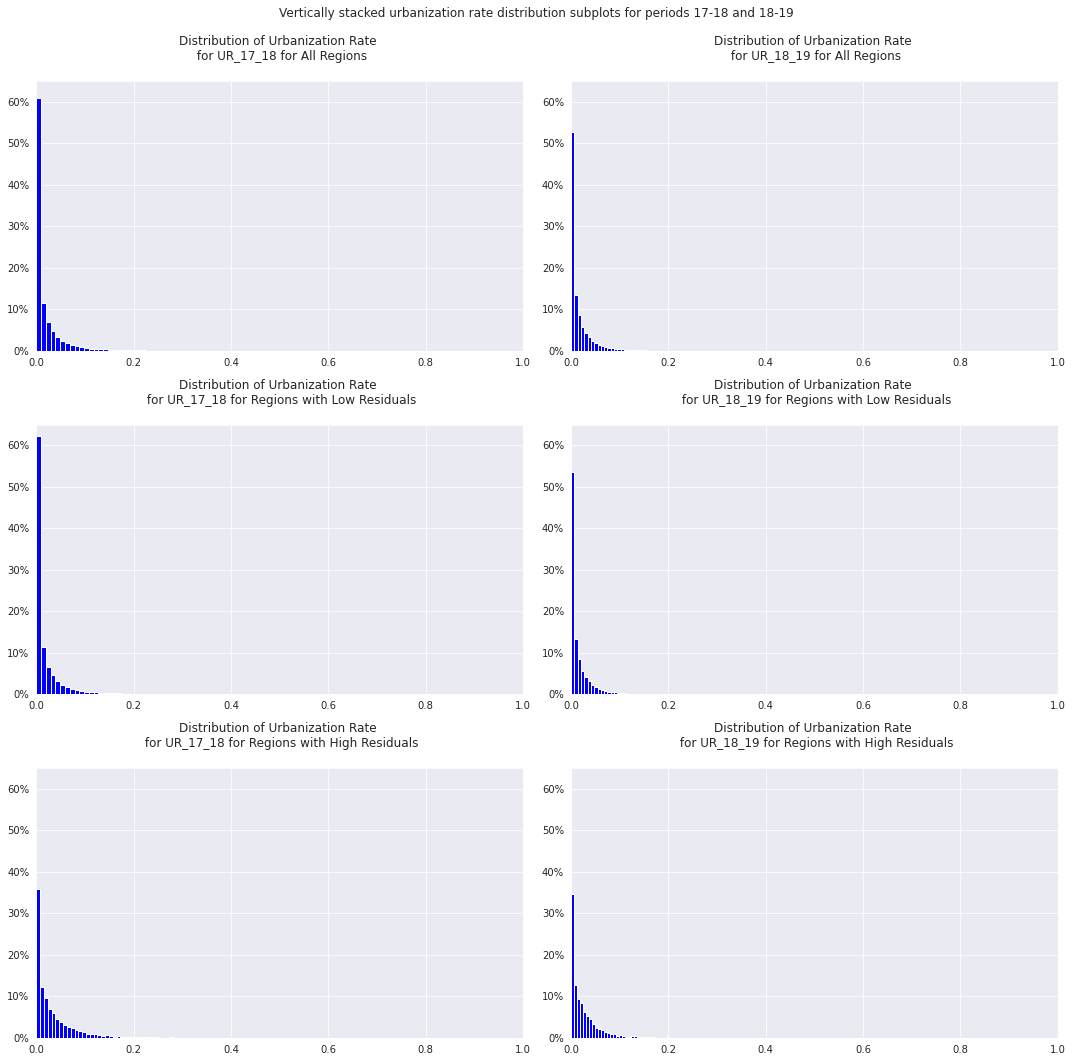

In [17]:
high_residual_URanalysis(results_df20, threshold=0.03)

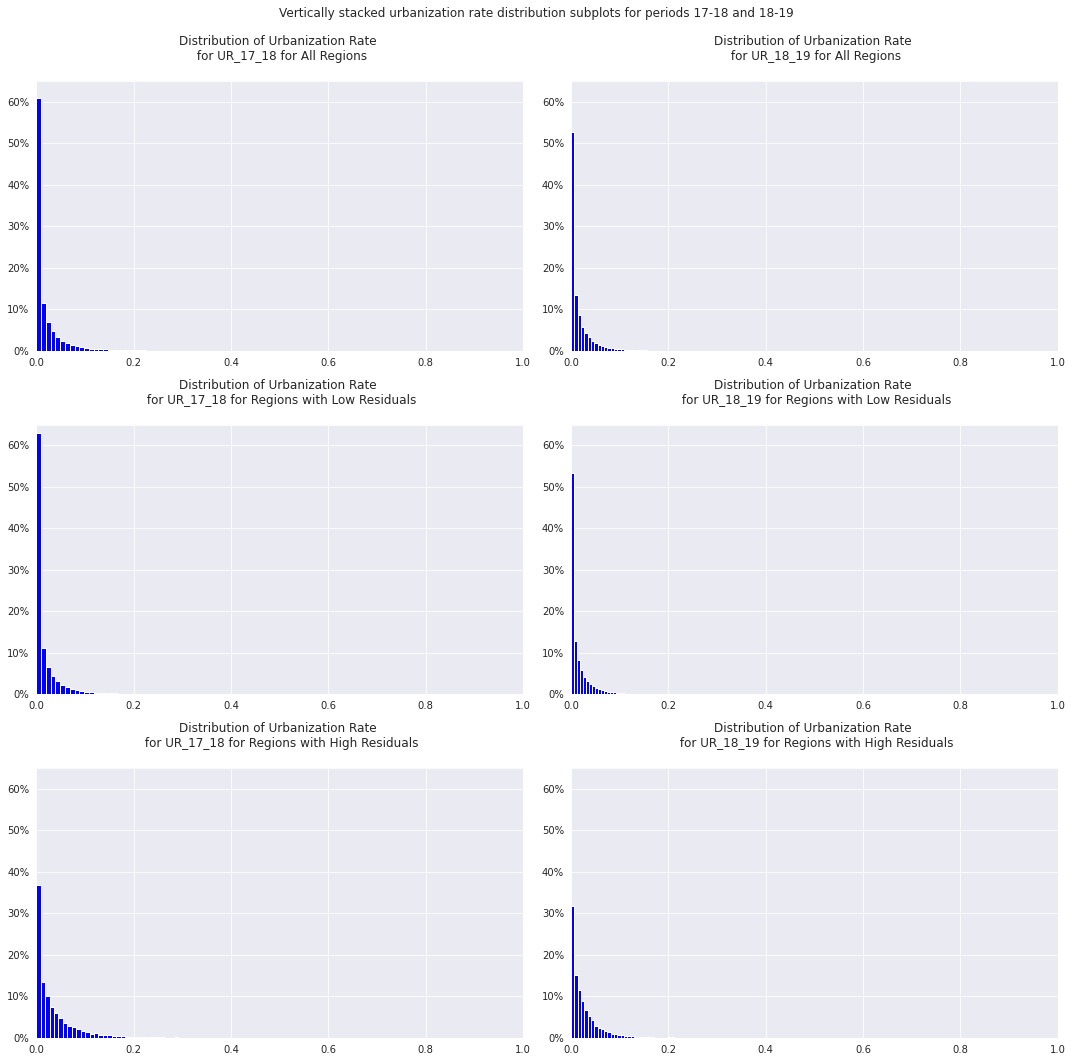

In [16]:
high_residual_URanalysis(results_df21, threshold=0.03)

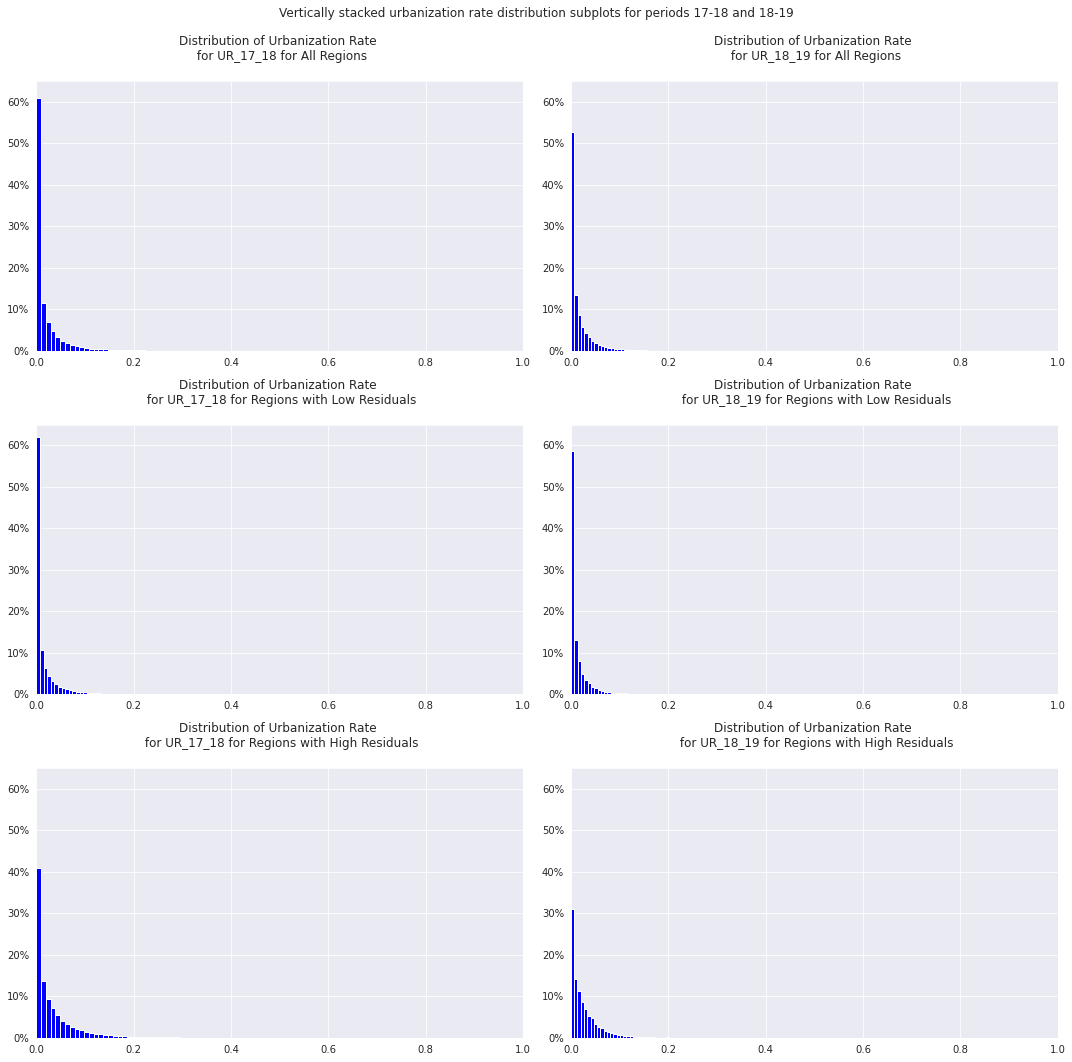

In [15]:
high_residual_URanalysis(results_df22, threshold=0.03)

In [49]:
## calculating average urbanization rate for high and low residuals
def avg_UR(df, residual_bins=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]):
    """
        get average urbanization rate per residual bin
        hypothesis: higher urbanization rate regions are harder to predict, maybe because dataset is imbalanced 
    """
    AUR = {}
    for i, start in enumerate(residual_bins[:-1]):
        end = residual_bins[i+1]
        res = list(df[(df.residuals>=start) & (df.residuals<end)].residuals)
        if res:
            avg_UR = mean(df[(df.residuals>=start) & (df.residuals<end)].residuals)
            AUR['[{}, {}]'.format(start, end)] = avg_UR
        else:
            AUR['[{}, {}]'.format(start, end)] = None
    x_axis = [(res+residual_bins[i+1])/2 for i,res in enumerate(residual_bins[:-1])]
    y_axis = list(AUR.values())
    plt.scatter(x_axis, y_axis)
    plt.xlabel("Mid-Residual Points")
    plt.ylabel("Average Urbanization Rate")
    plt.show()
    return AUR
    

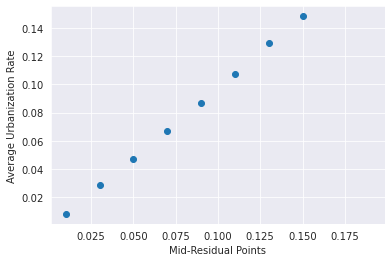

{'[0, 0.02]': 0.00786242497245028,
 '[0.02, 0.04]': 0.02824217752865447,
 '[0.04, 0.06]': 0.04720043635787851,
 '[0.06, 0.08]': 0.06701199169628244,
 '[0.08, 0.1]': 0.08661629649946324,
 '[0.1, 0.12]': 0.10759962935645627,
 '[0.12, 0.14]': 0.1295409445902411,
 '[0.14, 0.16]': 0.1485554980039596,
 '[0.16, 0.18]': None,
 '[0.18, 0.2]': None}

In [53]:
AUR = avg_UR(results_df20)
AUR

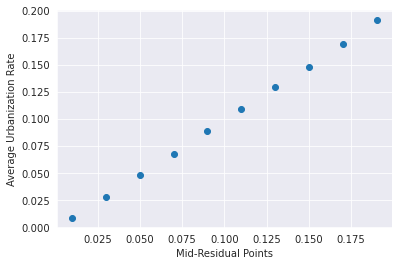

{'[0, 0.02]': 0.008627445560607478,
 '[0.02, 0.04]': 0.027899750298657988,
 '[0.04, 0.06]': 0.047917825272986436,
 '[0.06, 0.08]': 0.06788527572551743,
 '[0.08, 0.1]': 0.08882765229989378,
 '[0.1, 0.12]': 0.1089681745681558,
 '[0.12, 0.14]': 0.12926546667515948,
 '[0.14, 0.16]': 0.1485101871722736,
 '[0.16, 0.18]': 0.16922348888248934,
 '[0.18, 0.2]': 0.1912835506039847}

In [52]:
AUR = avg_UR(results_df21)
AUR

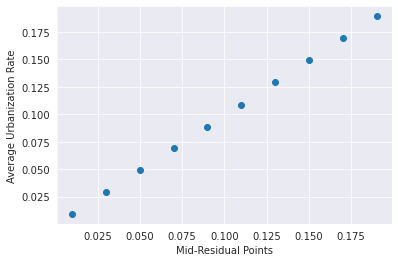

{'[0, 0.02]': 0.009260390026724234,
 '[0.02, 0.04]': 0.029342385394937564,
 '[0.04, 0.06]': 0.04923640374436724,
 '[0.06, 0.08]': 0.06961778516241736,
 '[0.08, 0.1]': 0.08830469824605001,
 '[0.1, 0.12]': 0.10866984529709216,
 '[0.12, 0.14]': 0.1290820929194446,
 '[0.14, 0.16]': 0.14899402930439756,
 '[0.16, 0.18]': 0.16919674819824768,
 '[0.18, 0.2]': 0.18925999663383797}

In [55]:
AUR = avg_UR(results_df22)
AUR

### R2 for datapoints with urbanization >= 0.1

<AxesSubplot:>

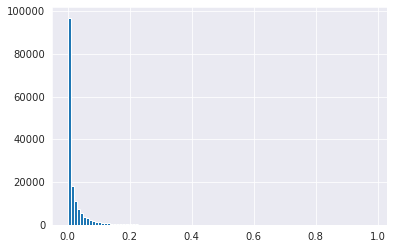

In [29]:
# R2 for data with high urbanization rate 
results_df20.UR_17_18.hist(bins=100)

Text(0, 0.5, 'Urbanization Prediction')

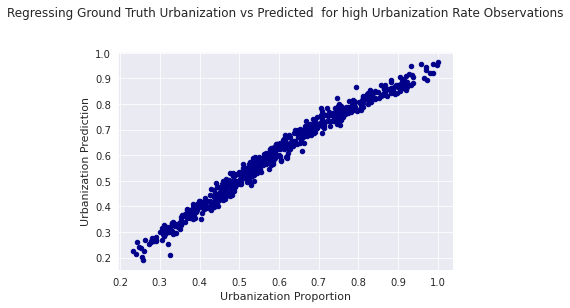

In [51]:
filtered = results_df20[(results_df20.UR_18_19>=0.1) & (results_df20.UR_17_18>=0.11)]
### checking how closely the target variable relates to the predictions
filtered.plot.scatter(x='Y', y='Pred', c='DarkBlue')
plt.title('Regressing Ground Truth Urbanization vs Predicted  for high Urbanization Rate Observations\n\n')
plt.xlabel('Urbanization Proportion', fontsize=11)
plt.ylabel('Urbanization Prediction', fontsize=11)

In [52]:
# BASELINE: Use previous year as the prediction for the next year
slope_b, intercept_b, r_value_b, p_value_b, std_err_b = scipy.stats.linregress(filtered['2019'], filtered['2022'])
# MODEL PREDICTION: Use ConvLSTM model to predict urbanization in the next year
slope_m, intercept_m, r_value_m, p_value_m, std_err_m = scipy.stats.linregress(filtered['Y'], filtered['Pred'])

print('Baseline Perfformance:')
print('slope:', slope_b)
print('intercept:', intercept_b)
print('r_value:', r_value_b)
print('p_value:', p_value_b)
print('std_err:', std_err_b)
print()
print()
print('Model Performance:')
print('slope:', slope_m)
print('intercept:', intercept_m)
print('r_value:', r_value_m)
print('p_value:', p_value_m)
print('std_err:', std_err_m)

Baseline Perfformance:
slope: 0.9229996547486441
intercept: 0.11019353245015207
r_value: 0.9035050536767671
p_value: 3.255459067869385e-229
std_err: 0.01762615853548878


Model Performance:
slope: 0.9984682219759979
intercept: 0.004815833405485415
r_value: 0.9886536354957132
p_value: 0.0
std_err: 0.006107386958785152


### AI Summit plots

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
import random
from matplotlib.lines import Line2D
random.seed(10)

In [6]:
def LR_results(df, lags):
    """Fits a linear regression model on the data and returns the r2 score"""
    train, test = train_test_split(df, test_size=0.2)
    years_in = ['2017', '2018', '2019']
    X_train = train[years_in]
    X_test = test[years_in]
    r2scores = []
    for lag in lags:
        year_out = [str(int(years_in[-1])+lag+1)]
        y_train = train[year_out]
        y_test = test[year_out]
        model = LinearRegression().fit(X_train, y_train)
        r2scores.append(model.score(X_test, y_test))
    return r2scores
        


In [7]:
r2_scores = LR_results(results_df20, range(3))

In [8]:
# BASELINE
r2_scores

[0.9908824241257547, 0.9821592168355135, 0.971544139835941]

In [9]:
def ConvLSTM_results(dfs):
    """ Calculates the r2 scores of the ConvLSTM model for different years"""
    r2scores = []
    for df in dfs:
        _, _, r_value, _, _ = scipy.stats.linregress(df['Y'], df['Pred'])
        r2scores.append(r_value**2)
    return r2scores

In [10]:
r2_scores = ConvLSTM_results([results_df20,results_df21, results_df22])


In [11]:
# ConvLSTM
r2_scores

[0.995403259825429, 0.9897609862523348, 0.9710616756020171]

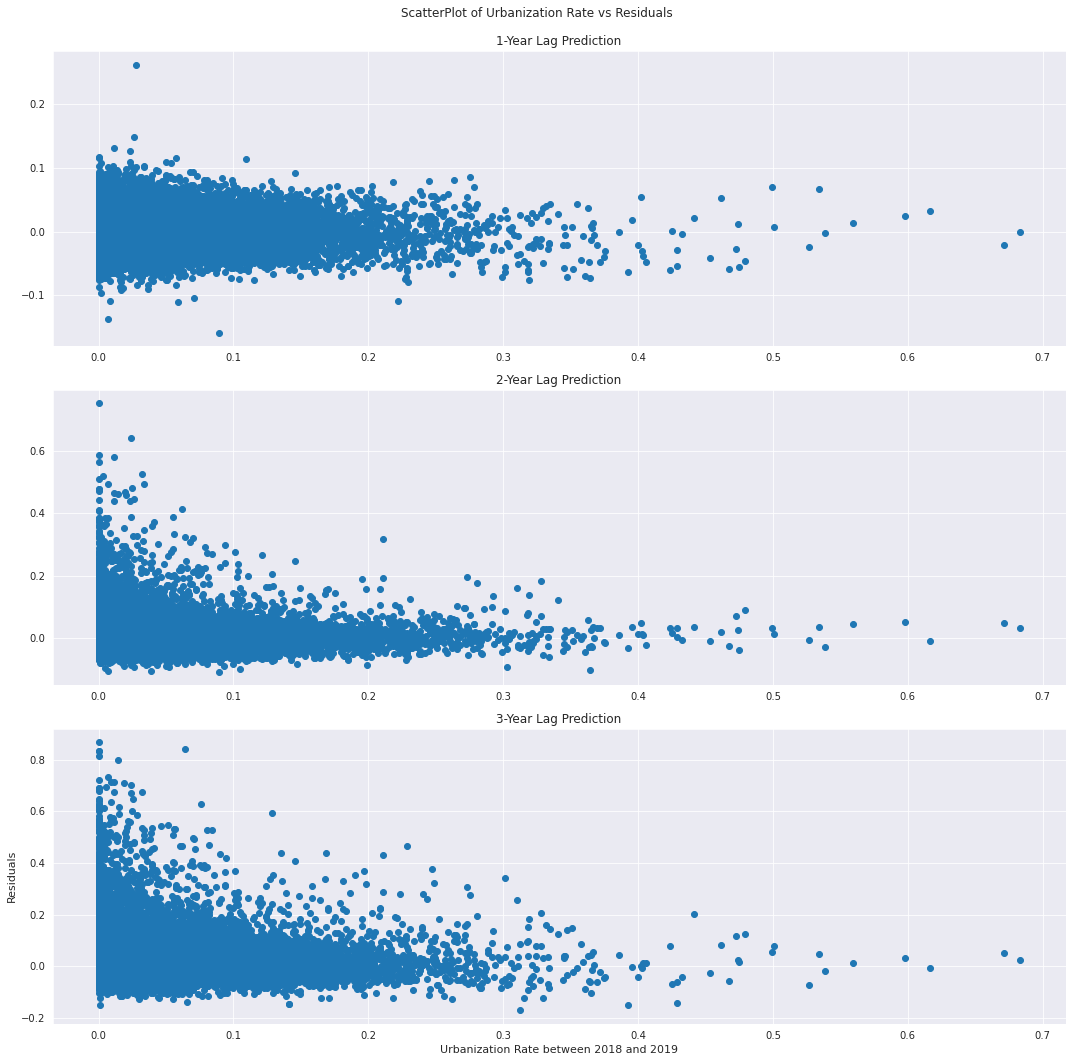

In [129]:
# Scatter plot of residuals vs urbanization rate

fig, ax = plt.subplots(nrows=3, ncols=1, tight_layout=True, figsize=(15,15))
fig.suptitle('ScatterPlot of Urbanization Rate vs Residuals\n')
comment_fill = ['1-Year Lag Prediction', '2-Year Lag Prediction', '3-Year Lag Prediction']
for i, tb in enumerate([results_df20, results_df21, results_df22]):
    ax[i].scatter(tb['UR_18_19'], tb['residuals'])
    ax[i].title.set_text(comment_fill[i])
    plt.xlabel('Urbanization Rate between 2018 and 2019', fontsize=11)
    plt.ylabel('Residuals', fontsize=11)


In [12]:
## calculating average urbanization rate for high and low residuals
def URvsRes(df, step):
    """
        get average residual per step of 500 observations
        calculate the average urbanization rate between the two years
        sort the observations in increasing order of urbanization rate
        hypothesis: higher urbanization rate regions are harder to predict
    """
    df['AVG_URB'] = (df['UR_17_18']+df['UR_18_19'])/2
    df = df.sort_values(by='AVG_URB')
    avg_urb = df['AVG_URB']
    residuals = df['residuals']
    prev_ind = 0
    mean_avg_urb = []
    mean_residuals = []
    for ind in range(0, len(df), step):
        mean_avg_urb.append(avg_urb[prev_ind:ind].mean())
        mean_residuals.append(residuals[prev_ind:ind].mean())
        prev_ind = ind
    return mean_avg_urb, mean_residuals
    # plt.scatter(mean_avg_urb, mean_residuals)
    # plt.xlim(0, 0.25)
    # plt.ylim(-0.02, 0.04)
    # plt.title('Mean Urbanization VS Residuals')
    # plt.xlabel("Mean Urbanization Rate per bin of 1000 observations")
    # plt.ylabel("Mean Residual per bin")
    # plt.show()


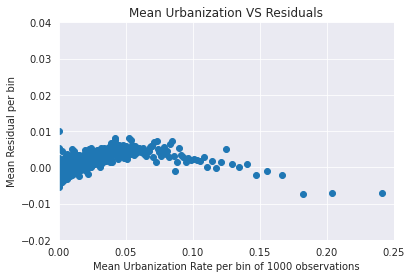

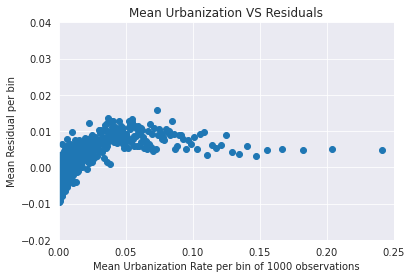

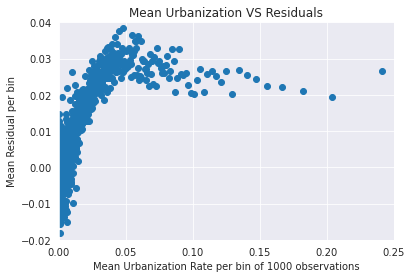

In [150]:
URvsRes(results_df20, 200)
URvsRes(results_df21, 200)
URvsRes(results_df22, 200)

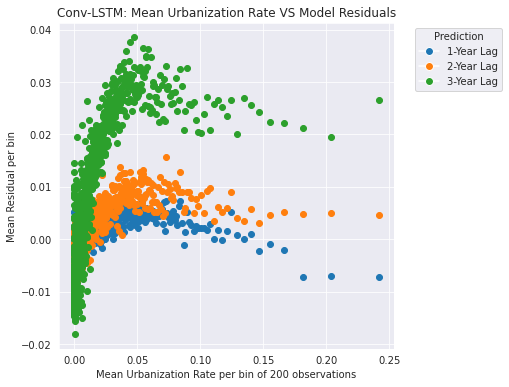

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

colors = {'1-Year Lag':'tab:blue', '2-Year Lag':'tab:orange', '3-Year Lag':'tab:green'}
step = 200
for i,df in enumerate([results_df20, results_df21, results_df22]):
    x, y = URvsRes(df, step=step)
    ax.scatter(x, y, c=list(colors.values())[i])
# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k,v in colors.items()]
ax.legend(title='Prediction', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Conv-LSTM: Mean Urbanization Rate VS Model Residuals')
plt.xlabel("Mean Urbanization Rate per bin of {} observations".format(step))
plt.ylabel("Mean Residual per bin")

plt.show()

In [14]:

def highUR_R2(dfs, max_UR_threshold=0.16, step = 0.005):
    """ Calculate the R2 of Linear Baseline and ConvLST video prediction models for observations with high Urbanization Rates """
    # scores_dict = {'Threshold':[],'R2 LR Predict-1Y':[], 'R2 LR Predict-2Y':[], 'R2 LR Predict-3Y':[], 'R2 VP Predict-1Y', 'R2 VP Predict-2Y', 'R2 VP Predict-3Y'])}
    scores = pd.DataFrame(columns=['Threshold','R2 LR Predict-1Y', 'R2 LR Predict-2Y', 'R2 LR Predict-3Y', 'R2 VP Predict-1Y', 'R2 VP Predict-2Y', 'R2 VP Predict-3Y'])
    t=0
    for i,j in enumerate(range(int(max_UR_threshold//step))):
        filtered20 = dfs[0][dfs[0]['AVG_URB']>=t]
        filtered21 = dfs[1][dfs[1]['AVG_URB']>=t]
        filtered22 = dfs[2][dfs[2]['AVG_URB']>=t]
        lr_r2scores = LR_results(filtered20, range(3))
        convlstm_r2scores = ConvLSTM_results([filtered20, filtered21, filtered22])
        scores.loc[i,:] = [t] + lr_r2scores + convlstm_r2scores
        t += step
    return scores
        

In [15]:
scores_df = highUR_R2([results_df20, results_df21, results_df22])

In [21]:
scores_df

,Threshold,R2 LR Predict-1Y,R2 LR Predict-2Y,R2 LR Predict-3Y,R2 VP Predict-1Y,R2 VP Predict-2Y,R2 VP Predict-3Y
0,0,0.991802,0.982757,0.971498,0.995403,0.989761,0.971062
1,0.005,0.989106,0.977144,0.96473,0.994108,0.987955,0.967512
2,0.01,0.987059,0.975066,0.964849,0.9935,0.986704,0.965125
3,0.015,0.985106,0.971548,0.958345,0.993004,0.986044,0.963309
4,0.02,0.981313,0.966732,0.95202,0.992635,0.985637,0.961913
5,0.025,0.980769,0.965958,0.950076,0.992312,0.984781,0.959307
6,0.03,0.979457,0.964413,0.951567,0.991934,0.984083,0.957151
7,0.035,0.975867,0.95721,0.938092,0.991495,0.983497,0.954326
8,0.04,0.971428,0.955028,0.934608,0.99103,0.983461,0.952226
9,0.045,0.967974,0.951549,0.932702,0.990658,0.983131,0.950161


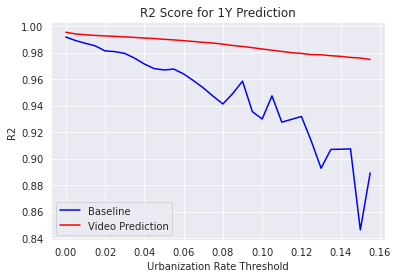

In [18]:
# plot lines
plt.plot(scores_df['Threshold'], scores_df['R2 LR Predict-1Y'], label = "Baseline", c = 'blue')
plt.plot(scores_df['Threshold'], scores_df['R2 VP Predict-1Y'], label = "Video Prediction", c = 'red')
plt.title('R2 Score for 1Y Prediction')
plt.xlabel('Urbanization Rate Threshold')
plt.ylabel('R2')
plt.legend()
plt.show()

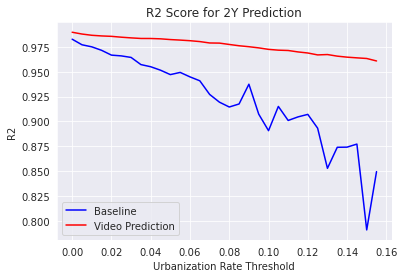

In [19]:
# plot lines
plt.plot(scores_df['Threshold'], scores_df['R2 LR Predict-2Y'], label = "Baseline", c = 'blue')
plt.plot(scores_df['Threshold'], scores_df['R2 VP Predict-2Y'], label = "Video Prediction", c = 'red')
plt.title('R2 Score for 2Y Prediction')
plt.xlabel('Urbanization Rate Threshold')
plt.ylabel('R2')
plt.legend()
plt.show()

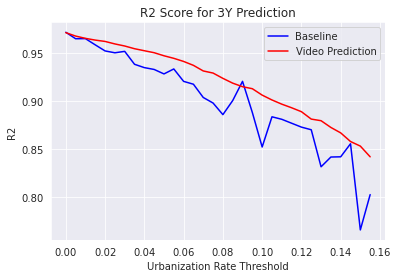

In [20]:
# plot lines
plt.plot(scores_df['Threshold'], scores_df['R2 LR Predict-3Y'], label = "Baseline", c = 'blue')
plt.plot(scores_df['Threshold'], scores_df['R2 VP Predict-3Y'], label = "Video Prediction", c = 'red')
plt.title('R2 Score for 3Y Prediction')
plt.xlabel('Urbanization Rate Threshold')
plt.ylabel('R2')
plt.legend()
plt.show()

In [108]:
prev_ind = 0
mean_avg_urb = []
mean_residuals = []
for ind in range(0, len(results_df20), 500):
    mean_avg_urb.append(avg_urb[prev_ind:ind].mean())
    mean_residuals.append(residuals[prev_ind:ind].mean())
    prev_ind = ind

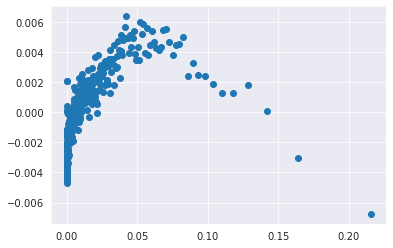

In [109]:
plt.scatter(mean_avg_urb, mean_residuals)

In [34]:
X_train = train[['2017', '2018', '2019']]
y_train = train[['2020']]
X_test = test[['2017', '2018', '2019']]
y_test = test[['2020']]

In [28]:
model = LinearRegression().fit(X_train, y_train)

In [37]:
model.score(X_train, y_train)

0.9916227693649057

In [35]:
model.score(X_test, y_test)

0.9911484157431982